In [2]:
from dotenv import load_dotenv

load_dotenv()

True

## Add Tools

In [3]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
   'title': "Beginner's Guide to LangGraph: Understanding State, Nodes, and ...",
   'content': 'Nodes: Nodes are the fundamental building blocks of a graph. Each node represents a specific function or operation that processes the current',
   'score': 0.838376,
   'raw_content': None},
  {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'content': '*   **Stateful Graph:** LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, al

### Use prebuilts

모델 정의 -> state 정의 -> node 정의 -> 그래프 생성 -> 그래프 실행


In [5]:
# 모델 정의
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [12]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# state 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

# tool 정의
tool = TavilySearch(max_results=2)  
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

# node 정의
def chatbot(state: State)->State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


tool_node = ToolNode(tools=tools)



# 그래프 생성
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)


graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

### Visualize Graph

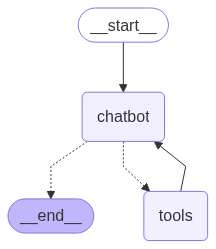

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 그래프 실행

In [17]:
from langchain_core.messages import HumanMessage


messages = {"messages": [HumanMessage(content="List all South Korean stocks that reached their daily upper limit on July 17th.")]}

graph.invoke(messages)

{'messages': [HumanMessage(content='List all South Korean stocks that reached their daily upper limit on July 17th.', additional_kwargs={}, response_metadata={}, id='dd3fe799-32a9-42f3-860c-20999a6cb135'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eRn96Ut0kHqMXeXlQnzBSW2x', 'function': {'arguments': '{"query":"South Korea stocks daily upper limit July 17 2023","time_range":"month","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 807, 'total_tokens': 844, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BuG9iZLgOUQH3jIWWPZ3y5kJlLBKz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs

## Add Memory

### checkpointer 정의 & graph 컴파일

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

### Interact with your chatbot

In [22]:
config = {"configurable": {"thread_id": "1"}}

In [30]:
user_input = "Hi there! My name is youngjun."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is youngjun.
================================== Ai Message ==================================

Hello, Youngjun! Nice to meet you. How can I assist you today?


In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Youngjun. How can I help you today?


In [34]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver


# state 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# tool 정의
@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)  
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

# node 정의
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

tool_node = ToolNode(tools=tools)

# 그래프 생성
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")



memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [ ]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': "Invalid 'messages': empty array. Expected an array with minimum length 1, but got an empty array instead.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'empty_array'}}